<a href="https://colab.research.google.com/github/octavianosilva/data_science/blob/main/An%C3%A1lise_RFM_e_Detec%C3%A7%C3%A3o_de_Anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Recência, Frequência e Valor Monetário (RFM)

<center><img alt='Análise RFM'  src='https://www.conteudoinboundmarketing.com.br/wp-content/uploads/2019/01/segmenta%C3%A7%C3%A3o-de-publico.png'></center>

Para um negócio, manter seus clientes fidelizados é muito mais importante que atrair novos clientes, isso porque o Custo de Aquisição de Cliente (CAC) é maior que o custo de retenção do cliente.

Com isso temos várias estratégias adotadas pelo setor de Marketing para engajar e reter os clientes que já consomem os produtos do negócio, e uma dessas estratégias é a Análise de Recência, Frequência e Valor Monetário do cliente, mais conhecida como **Análise RFM**. 

Essa estratégia tem como objetivo segmentar os clientes do negócio de acordo com suas semelhanças e para isso temos duas formas: 

1. Através do agrupamento dos clientes com base nos cálculos de sua recência, frequência e no quanto este cliente gera de receita para o negócio;

2. Através de uma pontuação com valores entre 1 a 5 atribuídos para cada métrica do cliente (Recência, Frequência e Valor Monetário).

Na primeira parte deste projeto iremos apenas realizar a segmentação com base nos valores brutos das métricas RFM que iremos calcular através das informações presentes na base de dados que utilizaremos.

Essa base de dados é referente a um negócio Inglês de vendas online dentro de um período de 8 meses que pode ser encontrada publicamente no [Kaggle](https://www.kaggle.com/datasets/vijayuv/onlineretail).

## Importando as bibliotecas e os dados

In [ ]:
# Importando o Pyforest
!pip install pyforest -q
import pyforest

# Importando o sklearn
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Importando o pacote da Lei de Benford para Python
!pip install benford_py
import benford as bf

!pip install benfordslaw
from benfordslaw import benfordslaw

# Ignorar os alertas de atualizações
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e4ccfe0169ee735ad327f9efbf66eff12562fff93eb63d2c0a94ccfcb37e95a3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Importando a base de dados do projeto que pode ser baixada no desafio do Kaggle: [Online Retail Data Set](https://www.kaggle.com/datasets/vijayuv/onlineretail).

In [ ]:
# Importando a base de dados do projeto
df_raw = pd.read_csv('OnlineRetail.csv', encoding = 'ISO-8859-1')

<IPython.core.display.Javascript object>

## Análise de Qualidade dos Dados

Antes de realizarmos a análise de RFM nos dados, precisamos checar como está a qualidade dos dados.

Vamos começar conhecendo quantas entradas e de colunas nossa base de dados possui:

In [ ]:
# Obtendo a quantidade de entradas e colunas da base de dados
print('A base de dados possui {} entradas e {} colunas.'.format(df_raw.shape[0],df_raw.shape[1]))

A base de dados possui 541909 entradas e 8 colunas.


Agora podemos checar as primeiras entradas da base de dados:

In [ ]:
# Checando as primeiras entradas da base de dados
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Como não temos uma documentação sobre essa base de dados, podemos interpretar as informações de cada coluna da seguinte forma:

* `InvoiceNo`: código de identificação do pedido de compra;

* `StockCode`: código de identificação do grupo do produto;

* `Description`: descrição do produto;

* `Quantity`: quantidade do produto no pedido;

* `InvoiceDate`: data e hora do pedido de compra;

* `UnitPrice`: preço unitário do produto;

* `CustomerID`: ID do cliente;

* `Country`: País em que o pedido de compra foi realizado.

É importante conhecer qual o tipo dos dados de cada uma das colunas presentes na base de dados: 

In [ ]:
# Obtendo os tipos de dados para cada coluna
df_raw.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Agora que sabemos os tipos de informações temos em cada coluna, vamos obter a quantidade de valores distintos temos em cada uma:

In [ ]:
# Obtendo a quantidade de valores distintos de cada coluna
df_raw.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Com as informações dos valores distintos, conseguimos algumas informações sobre o negócio de vendas online:

* Temos quase 26 mil pedidos de compras em um período de 8 meses;

* Nesse período de 8 meses foram vendidos mais de 4 mil tipos de produtos;

* Mais de 4 mil clientes em diversos países realizaram compras online no negócio.

Como podemos ter dados ausentes na base de dados, alguns valores distintos podem ser um pouco maiores, portanto para ter certeza precimos checar a quantidade de dados ausentes temos na nossa base de dados:

In [ ]:
# Obtendo a quantidade de dados ausentes total na base de dados
df_nulos = df_raw.copy() # copiando a base original para remover totalmente os valores nulos
df_nulos = df_nulos.dropna() # removendo todos as entradas com valores nulos
qtde_nulos = df_raw.shape[0] - df_nulos.shape[0] # calculando a quantidade total de entradas nulas na base de dados
pp_nulos = (qtde_nulos / df_raw.shape[0])*100 # calculando a proporção de dados ausentes na base de dados

# Exibindo os valores obtidos
print('Temos um total de {} entradas nulas, que correspondem a {:.2f}% da base de dados.'.format(qtde_nulos,pp_nulos))

Temos um total de 135080 entradas nulas, que correspondem a 24.93% da base de dados.


Temos quase 25% da nossa base de dados com valores ausentes, o que é uma proporção considerável para ser removida.

Vamos checar a quantidade de entradas ausentes em cada coluna em específico:

In [ ]:
# Checando a quantidade de entradas ausentes para cada coluna na base de dados
df_raw.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Checando a proporção de entradas ausentes para cada coluna na base de dados
df_raw.isnull().sum()/df_raw.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Podemos ver que todas as ocorrências de dados ausentes estão na coluna `CustomerID`, o que é um problema para nossa análise RFM já que ela é voltada ao cliente. Como não temos como rastrear os ID ausentes - se atribuírmos ID's temporários poderíamos perder essas entradas entre as verdadeiras e complicar bastante na identificação dos clientes em uma situação real -, e como as entradas ausentes na coluna `Description` são bem poucas, vamos optar por remover toda a ausência de dados da base.

Caso a proporção de quase 25% de dados ausentes na coluna `CustomerID` estivessem dispersa entre as outras colunas, poderíamos realizar alguns tratamentos para aproveitar o máximo de informação, minizando a quantidade de entradas ausentes que seriam removidas.

Por fim, vamos analisar como estão nosso dados estatisticamente:

In [ ]:
# Obtendo o resumo estatístico da base de dados sem dados ausentes
df_nulos[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Observando o resumo estatístico acima, podemos perceber alguns pontos interessantes, como:

* Temos quantidades de produtos no pedido abaixo de 0, dessa forma podemos imaginar que o cliente está entregando produtos e não comprando, o que não faz sentido por ser um pedido de compra, dessa forma podemos levantar a hipótese de que esses valores foram de alguma forma inseridos de forma errada;

* Temos valores de produtos abaixo de 0, ou seja, clientes estão recebendo dinheiro ao invés de gastar comprando online no negócio, o que também não faz sentido, reforçando a hipótese de que temos valores inseridos de forma errada;

* Também podemos perceber que temos outliers bastante expressivas, onde temos valores bem baixos para 75% de toda a base de dados e valores extremamente altos como o valor máximo das colunas.

Outliers também são um problema para se ter segmentações de clientes precisas, portanto é necessário analisarmos mais a fundo essas entradas com valores discrepantes.

Vamos começar observando as entradas que possuem quantidades de produtos em seus pedidos iguais a zero:

In [ ]:
# Checando as entradas com quantidade de produtos iguais a zero em seus pedidos
df_nulos.loc[df_nulos['Quantity'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Não temos nenhum pedido que tenha algum produto em zero quantidades, o que até então parece estar correto, mas vamos confirmar agora o que vimos com o resumo estatístico, isto é, vamos checar as entradas com quantidades de produtos abaixo de zero:

In [ ]:
# Checando as entradas com quantidade de produtos abaixo de zero em seus pedidos
df_nulos.loc[df_nulos['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [ ]:
# Calculando a proporção de entradas com quantidades de produtos abaixo de zero
df_nulos.loc[df_nulos['Quantity'] < 0].shape[0]/df_nulos.shape[0]*100

2.188880340388714

Podemos ver que 2% dos nossos dados possuem pedidos com quantidades de produtos negativas, mas que ao olharmos algumas dessas entradas, podemos levar a hipótese que esses valores foram apenas inseridos no sistema de forma errada com valores negativos.

Levando essa hipótese em consideração, iremos converter os valores negativos para valores positivos na coluna `Quantity`, porém em uma situação com dados de varejo reais, seria bastante importante conhecer a regra de negócio, pois quantidades com valores negativos podem ter significados relevantes, como por exemplo, informar devoluções de produtos.

Agora que vimos o caso dos valores negativos, vamos analisar o caso das outliers positivas, mesmo que um valor discrepante seja prejuducial estatisticamente falando, não quer dizer que esse valor não seja relevante, afinal sempre existem clientes que vão realizar compras em grandes quantidades para alguma ocasião específica, e esse cliente é uma pessoa importante para a renda do negócio.
Assim, para conservarmos as entradas desses clientes considerados outliers, vamos normalizar os dados com a técnica de padronização para ao menos reduzir os impactos desses clientes. 

Agora que analisamos a coluna de quantidade de produtos, vamos analisar a coluna de preços unitários dos produtos (`UnitPrice`), começando checando os produtos com valores em zero:

In [ ]:
# Checando as entradas com preços unitários de produtos iguais a zero
df_nulos.loc[df_nulos['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom


Observando as entradas que possuem valores unitário de produto iguais a zero, a primeira hipótese que podemos lavantar é de que esses valores foram inseridos de forma errada nessas entradas, e para confirmar essa hipótese podemos consultar a coluna `Description` e pesquisar por um dos produtos com custos em zero:

In [ ]:
# Checando as entradas que possuem o mesmo produto que uma das entradas onde ele está inserido como 0
df_nulos.loc[df_nulos['Description'] == 'ROUND CAKE TIN VINTAGE GREEN'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3925,536738,22841,ROUND CAKE TIN VINTAGE GREEN,2,12/2/2010 13:06,7.95,15827.0,United Kingdom
5111,536844,22841,ROUND CAKE TIN VINTAGE GREEN,2,12/2/2010 18:49,7.95,14236.0,United Kingdom
5328,536859,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/3/2010 10:43,7.95,12841.0,United Kingdom
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.00,12647.0,Germany
9543,537207,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 15:06,7.95,17402.0,United Kingdom


Com essa pesquisa de produto acima, já podemos confirmar nossa primeira hipótese de que os valores em zero estão na verdade, inseridos de forma errada na base de dados.

Iremos então alterar os valores em zero pelo valor correto através da pesquisa de produtos.

Para as outliers dessa coluna também não iremos realizar nenhum ação além do próprio método de normalização que mencionamos para a coluna de quantidade de produtos. 

Agora que exploramos mais a fundo os caso dos valores negativos e discrepantes nas colunas numéricas, chegamos às seguintes conclusões:

* Vamos converter os valores negativos na coluna `Quantity` para positivos;

* Iremos alterar os valores dos produtos que estão em zero por seus respectivos valores corretos, embora fosse mais conveniente apenas remover essas entradas por serem bem poucas em relação a toda a base de dados;

* Vamos conservar as entradas consideradas outliers, mas iremos aplicar um método de normalização para reduzir os impactos;

## Tratando os Dados

Como já temos uma variável que possui a base de dados já com as entradas com valores ausentes removidas, não precisaremos passar por este passo novamente.

In [ ]:
# Copiando a base de dados sem dados ausentes para essa 
df_clean = df_nulos.copy()

Vamos realizar o primeiro passo que definimos acima que é a conversão dos valores negativos na coluna `Quantity`:

In [ ]:
# Convertendo os valores negativos da coluna Quantity para positivos
df_clean['Quantity'] = df_clean['Quantity'].abs()

Podemos checar se houve a mudança chamando novamente o resumo descritivo da base de dados:

In [ ]:
# Checando se os valores negativos foram convertidos em positivos
df_clean['Quantity'].describe()

count    406829.000000
mean         13.412279
std         248.624170
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Podemos ver que não temos mais valores negativos na coluna de quantidade de produtos, então iremos avançar para a próxima etapa de tratamento: converter os valores de produtos inseridos de forma errada pelos respectivos valores corretos.

Para isso, precisamos obter uma lista com os produtos que estão com seus valores em zero:

In [ ]:
# Obtendo uma lista com os produtos que possuem valores zero
df_zeros = df_clean.loc[df_clean['UnitPrice'] == 0]
lista_produtos = list(df_zeros['Description'].unique())

In [ ]:
# Observando os produtos na lista
lista_produtos

['ROUND CAKE TIN VINTAGE GREEN',
 'ADVENT CALENDAR GINGHAM SACK',
 'REGENCY CAKESTAND 3 TIER',
 'PAPER BUNTING RETROSPOT',
 'PLASTERS IN TIN SKULLS',
 'ORGANISER WOOD ANTIQUE WHITE ',
 'FAIRY CAKES NOTEBOOK A6 SIZE',
 'CERAMIC BOWL WITH LOVE HEART DESIGN',
 'MINI CAKE STAND  HANGING STRAWBERY',
 'HEART GARLAND RUSTIC PADDED',
 'CHILDS BREAKFAST SET CIRCUS PARADE',
 'PARTY BUNTING',
 'SET OF 6 SOLDIER SKITTLES',
 ' OVAL WALL MIRROR DIAMANTE ',
 'JAM MAKING SET WITH JARS',
 'Manual',
 'SET OF 6 NATIVITY MAGNETS ',
 'SET OF 2 CERAMIC PAINTED HEARTS ',
 'SET OF 2 CERAMIC CHRISTMAS REINDEER',
 '36 FOIL STAR CAKE CASES ',
 'POLKADOT RAIN HAT ',
 'PADS TO MATCH ALL CUSHIONS',
 'GLASS CLOCHE SMALL',
 'PASTEL COLOUR HONEYCOMB FAN',
 'BISCUIT TIN VINTAGE CHRISTMAS',
 'CHRISTMAS PUDDING TRINKET POT ',
 'JUMBO BAG SPACEBOY DESIGN',
 'RED KITCHEN SCALES',
 "CHILDREN'S APRON DOLLY GIRL ",
 'MINI LIGHTS WOODLAND MUSHROOMS',
 'SET OF 9 BLACK SKULL BALLOONS',
 'PAPER BUNTING VINTAGE PAISLEY',
 'HANGING

Vamos checar se houve flutuações de preços em um desses produtos no período de 8 meses:

In [ ]:
# Checando os valores que um produto teve em um período de 8 meses
df_clean['UnitPrice'].loc[df_clean['Description'] == 'ROUND CAKE TIN VINTAGE GREEN'].unique()

array([ 7.95,  0.  ,  6.95,  5.49, 15.79])

Nesse período de 8 meses tivemos quatro valores para o mesmo produto (considerando que o valor 0 seja um erro), o que é bastante comum de ocorrer onde se vende produtos ou serviços devido a diversos fatores que influenciam no reajuste de preços.

Como temos apenas 40 pedidos de compra com produtos com valores em zero em uma base de dados com quase 542 mil pedidos, iremos apenas converter o valor zero pelo primeiro valor que temos de um produto, sem considerar o reajuste de preço na data do pedido.

Caso o número de pedidos fossem maiores, seria importante atribuir o valor correto do produto de acordo com o reajuste, ou seja, teríamos que pegar o valor do produto com base na data do pedido.

In [ ]:
# Obtendo os valores corretos de cada um dos produtos listado
lista_valores = []

for i in lista_produtos:
  valor_correto = df_clean['UnitPrice'].loc[df_clean['Description'] == i]
  lista_valores.append(valor_correto.head(1).item())

In [ ]:
# Checando os valores dos produtos obtidos
lista_valores

[7.95,
 5.95,
 10.95,
 2.95,
 1.65,
 8.5,
 0.65,
 2.95,
 1.45,
 2.95,
 8.5,
 4.65,
 3.75,
 9.95,
 4.25,
 1.25,
 2.08,
 1.45,
 1.45,
 2.1,
 0.32,
 0.001,
 3.95,
 1.65,
 2.89,
 1.45,
 1.95,
 8.5,
 2.1,
 3.29,
 0.85,
 2.95,
 1.65,
 9.95,
 0.85]

Agora que temos os valores de cada produto, vamos criar uma função com os critérios para realizar as conversões de valores:

In [ ]:
# Definindo os critérios em uma função
def correcao_valores(row):
  if row['UnitPrice'] > 0:
    return row['UnitPrice']

  elif row['UnitPrice'] == 0:
    if row['Description'] == 'ROUND CAKE TIN VINTAGE GREEN':
      return 7.95

    if row['Description'] == 'ADVENT CALENDAR GINGHAM SACK':
      return 5.95

    if row['Description'] == 'REGENCY CAKESTAND 3 TIER':
      return 10.95

    if row['Description'] == 'PAPER BUNTING RETROSPOT':
      return 2.95

    if row['Description'] == 'PLASTERS IN TIN SKULLS':
      return 1.65

    if row['Description'] == 'ORGANISER WOOD ANTIQUE WHITE ':
      return 8.5

    if row['Description'] == 'FAIRY CAKES NOTEBOOK A6 SIZE':
      return 0.65

    if row['Description'] == 'CERAMIC BOWL WITH LOVE HEART DESIGN':
      return 2.95

    if row['Description'] == 'MINI CAKE STAND  HANGING STRAWBERY':
      return 1.45

    if row['Description'] == 'HEART GARLAND RUSTIC PADDED':
      return 2.95

    if row['Description'] == 'CHILDS BREAKFAST SET CIRCUS PARADE':
      return 8.5

    if row['Description'] == 'PARTY BUNTING':
      return 4.65

    if row['Description'] == 'SET OF 6 SOLDIER SKITTLES':
      return 3.75

    if row['Description'] == ' OVAL WALL MIRROR DIAMANTE':
      return 9.95

    if row['Description'] == 'JAM MAKING SET WITH JARS':
      return 4.25

    if row['Description'] == 'Manual':
      return 1.25

    if row['Description'] == 'SET OF 6 NATIVITY MAGNETS ':
      return 2.08

    if row['Description'] == 'SET OF 2 CERAMIC PAINTED HEARTS ':
      return 1.45

    if row['Description'] == 'SET OF 2 CERAMIC CHRISTMAS REINDEER':
      return  1.45

    if row['Description'] == '36 FOIL STAR CAKE CASES ':
      return 2.1

    if row['Description'] == 'POLKADOT RAIN HAT ':
      return 0.32

    if row['Description'] == 'PADS TO MATCH ALL CUSHIONS':
      return 0.001

    if row['Description'] == 'GLASS CLOCHE SMALL':
      return 3.95

    if row['Description'] == 'PASTEL COLOUR HONEYCOMB FAN':
      return 1.65

    if row['Description'] == 'BISCUIT TIN VINTAGE CHRISTMAS':
      return 2.89

    if row['Description'] == 'CHRISTMAS PUDDING TRINKET POT ':
      return 1.45

    if row['Description'] == 'JUMBO BAG SPACEBOY DESIGN':
      return 1.95

    if row['Description'] == 'RED KITCHEN SCALES':
      return 8.5

    if row['Description'] == "CHILDREN'S APRON DOLLY GIRL ":
      return 2.1

    if row['Description'] == 'MINI LIGHTS WOODLAND MUSHROOMS':
      return 3.29

    if row['Description'] == 'SET OF 9 BLACK SKULL BALLOONS':
      return 0.85

    if row['Description'] == 'PAPER BUNTING VINTAGE PAISLEY':
      return 2.95

    if row['Description'] == 'HANGING METAL HEART LANTERN':
      return 1.65

    if row['Description'] == 'SET OF 2 TRAYS HOME SWEET HOME':
      return 9.95

    if row['Description'] == 'ASSTD DESIGN 3D PAPER STICKERS':
      return 0.85

Agora que temos a função com os critérios de conversão definida, vamos aplicar a conversão na base de dados:

In [ ]:
# Aplicando a função com os critérios de conversões definida
df_clean['UnitPrice'] = df_clean.apply(lambda row: correcao_valores(row), axis=1)

In [ ]:
# Checando o menor valor que temos de produto
df_clean['UnitPrice'].min()

0.001

Nossa função de conversão funcionou corretamente, não temos mais valores iguais a zero.

Antes de avançarmos para a etapa de normalização dos dados que pontuamos anteriormente, precisamos passar por uma etapa de estruturação de dados para a análise RFM.

Existem quatro características que precisamos para realizar uma análise RFM, onde o próprio nome já informa três delas: Recência, Frequência e Valor Monetário, e como essa análise é voltada para a classificação de cliente, a identificação deste cliente se torna a quarta característica necessária.

Dessas quatro características citadas, temos apenas a identificação do cliente (`CustomerID`) pronta para uso, as demais características estão ocultas entre as colunas da base de dados, por exemplo, não temos uma coluna que informa o valor total do pedido do cliente (Valor Monetário), temos apenas a quantidade de produtos e o valor unitário. 

Dessa forma iremos precisar tornar essas características visíveis para que possamos realizar nossa análise, e para isso iremos seguir os seguintes passos:

* Recência (R): iremos calcular essa característica através da subtração da data de pedido mais recente na base de dados com a data do último pedido do cliente utilizando a coluna `InvoiceDate` como referência. 

* Frequência (F): para calcular a característica de frequência iremos contar a quantidade de pedidos realizados para cada cliente utilizando a coluna `InvoiceNo` como referência; e

* Valor Monetário (M): para termos a característica de valor, iremos calcular o valor total do pedido do cliente utilizando as colunas `Quantity` e `UnitPrice` como referência.

### Calculando a Recência (R)

Vimos durante a observação dos tipos das colunas que temos na nossa base de dados que a coluna `InvoiceDate` está com o tipo objeto e não datetime, então primeiro vamos tratar essa coluna:

In [ ]:
# Checando o tipo da coluna InvoiceDate
df_clean['InvoiceDate'].dtype

dtype('O')

In [ ]:
# Transformando a coluna InvoiceDate para o tipo 'datetime'
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'],format='%m/%d/%Y %H:%M')

# Conferindo se o tipo da coluna foi realmente alterada
df_clean['InvoiceDate'].dtype

<IPython.core.display.Javascript object>

dtype('<M8[ns]')

Agora podemos calcular a recência do cliente através da subtração da data do último pedido do cliente pela data do pedido mais recente na base de dados:

In [ ]:
# Calculando a diferença entre as datas dos pedidos
df_clean['Dif_time'] = max(df_clean['InvoiceDate']) - df_clean['InvoiceDate']

In [ ]:
# Criando um DataFrame para agrupar as diferenças de datas pelos clientes e selecionando a data mais recente
recencia = df_clean.groupby('CustomerID')['Dif_time'].min()
recencia = recencia.reset_index()

In [ ]:
# Visualizando o DataFrame criado com a recência
recencia.head()

,CustomerID,Dif_time
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


Como estamos lidando com diferenças de dias, semanas e meses, não precisamos do horário:

In [ ]:
# Removendo a parte das horas da coluna Dif_time
recencia['Dif_time'] = recencia['Dif_time'].dt.days

# Visualizando novamente o DataFrame
recencia.head()

,CustomerID,Dif_time
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


Agora que calculamos a recência e a deixamos preparada em um DataFrame, vamos calcular a Frequência (F).

### Calculando a Frequência (F)

Para calcular a Frequência basta contar quantos pedidos temos de cada cliente na base de dados através da coluna `InvoiceNo`:

In [ ]:
# Calculando o total de pedidos para cada cliente
frequencia = df_clean.groupby('CustomerID')['InvoiceNo'].count()
frequencia = frequencia.reset_index()

# Visualizando o DataFrame com a frequência dos clientes
frequencia.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Acima temos a Frequência dos clientes calculada em um novo DataFrame.

Podemos então ir para a última etapa que é calcular o Valor Monetário dos clientes.

### Calculando o Valor Monetário (M)

Para termos o Valor Monetário de cada cliente, basta calcular o valor total de cada pedido do cliente e depois somar o valor desses pedidos:

In [ ]:
# Calculando o Valor Monetário dos clientes
df_clean['Valor_Pedido'] = df_clean['Quantity']*df_clean['UnitPrice']

# Criando um DataFrame para monetização que será a soma do valor de todos os pedidos do cliente
monetizacao = df_clean.groupby('CustomerID')['Valor_Pedido'].sum()
monetizacao = monetizacao.reset_index()

# Visualizando o DataFrame de Monetização
monetizacao.head()

,CustomerID,Valor_Pedido
0,12346.0,154367.20
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Com esse DataFrame temos nossa última característica necessária para realizarmos a análise RFM.

Como temos um DataFrame separado para cada característica calculada, vamos uní-las em um único DataFrame:

In [ ]:
# Unindo todas as características em um único DataFrame
df_rfm = pd.merge(recencia, frequencia, on='CustomerID', how='inner')
df_rfm = pd.merge(df_rfm, monetizacao, on='CustomerID', how='inner')

# Trocando os nomes das colunas para facilitar na identificação das características
df_rfm.columns = ['CustomerID','Recencia','Frequencia','Monetizacao']

# Visualizando o novo DataFrame
df_rfm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,CustomerID,Recencia,Frequencia,Monetizacao
0,12346.0,325,2,154367.20
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
...,...,...,...,...
4367,18280.0,277,10,180.60
4368,18281.0,180,7,80.82
4369,18282.0,7,13,179.50
4370,18283.0,3,756,2094.88


Anteriormente vimos que existem outliers nos dados, então essas outliers também foram refletidas nesso novo DataFrame para a análise RFM, por isso foi necessário estruturar e calcular as características antes de normalizarmos os dados.

Vamos ver um exemplo das outliers com os dados não normalizados:

<IPython.core.display.Javascript object>

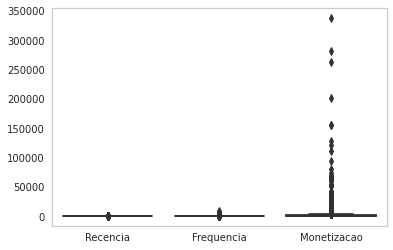

In [ ]:
# Visualizando os boxplots de maneira geral
sns.boxplot(data=df_rfm[['Recencia','Frequencia','Monetizacao']]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

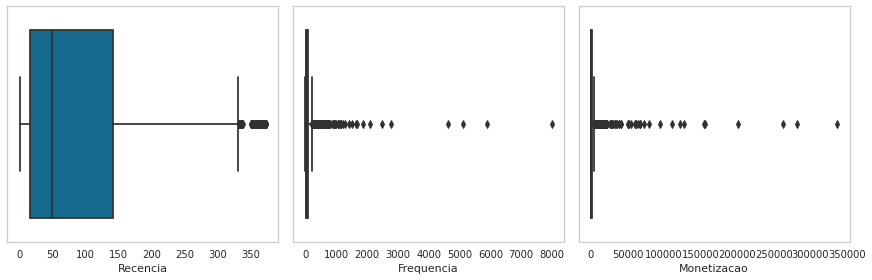

In [ ]:
# Visualizando os boxplots das características de maneira mais detalhada
sns.set_style("whitegrid", {'axes.grid' : False})

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.boxplot(df_rfm['Recencia'], ax=ax[0])
sns.boxplot(df_rfm['Frequencia'], ax=ax[1])
sns.boxplot(df_rfm['Monetizacao'], ax=ax[2])

plt.tight_layout();

Devido a outliers bem discrepantes não conseguimos visualizar os boxplots, o que demonstra os impactos que elas podem causar em análises estatísticas.

Agora vamos aplicar um método de normalização nos dados conhecido como *StandardScaler*, além disso vamos selecionar apenas as colunas das características por enquanto:

In [ ]:
# Instanciando o StandardScaler para normalizar os dados
std = StandardScaler()

# Selecionando as colunas Recencia, Frequencia e Monetizacao
rfm_normalizada = df_rfm[['Recencia','Frequencia','Monetizacao']]

# Normalizando os dados
rfm_normalizada = std.fit_transform(rfm_normalizada)

# Criando um DataFrame para os dados normalizados
df_rfm_normalizada = pd.DataFrame(rfm_normalizada)
df_rfm_normalizada.columns = ['Recencia','Frequencia','Monetizacao']

# Visualizando o DataFrame com os dados normalizados
df_rfm_normalizada.head()

<IPython.core.display.Javascript object>

,Recencia,Frequencia,Monetizacao
0,2.322023,-0.391720,14.478609
1,-0.893733,0.382657,0.202528
2,-0.169196,-0.266959,-0.036530
3,-0.725005,-0.086271,-0.040306
4,2.163220,-0.327188,-0.175701


Deixamos de lado a coluna `CustomerID` para que possamos realizar a etapa de clustering com o KMeans, pois se ela estivesse presente durante essa etapa, o KMeans iria considerar os IDs dos clientes como uma informação com o mesmo grau de relevância das características, o que seria errado.

Dito isso, iremos realizar a etapa de clusterização com os dados normalizados dessas três características e então acrescentar novamente a coluna `CustomerID` quando tivermos os grupos (clusters) identificados.

## Aplicando o KMeans para agrupar os clientes com base na análise RFM

Agora que temos os dados tratados e preparados para identificarmos nossos clientes mais relevantes para o negócio, vamos realizar a etapa de agrupamento com o KMeans.

Para identificarmos o número ótimo de agrupamentos que podemos ter com nossos dados, temos a *Regra do Cotovelo* ou *Elbow Rule* em inglês:

In [ ]:
# Definindo um loop para testarmos de 1 a 10 agrupamentos
ks = range(1,10)
inertias = []

# Executando o loop de testes
for k in ks:
  # Instanciando o modelo KMeans para o número de agrupamentos K especificado pelo loop de teste
  model = KMeans(n_clusters= k)

  # Adaptando o modelo
  model.fit(df_rfm_normalizada)

  # Adicionando o valor da inércia na lista
  inertias.append(model.inertia_)

Agora vamos plotar o gráfico para a Regra do Cotovelo (Elbow Rule) com os resultados dos testes:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

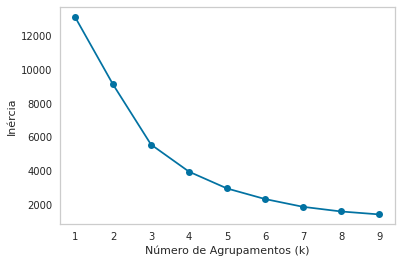

In [ ]:
# Plotando o gráfico da Regra do Cotovelo (Elbow Rule)
plt.plot(ks, inertias, '-o')
plt.xlabel('Número de Agrupamentos (k)')
plt.ylabel('Inércia')
plt.xticks(ks)
plt.show()

Pela Regra do Cotovelo, vemos que a dobra ocorreu no número de agrupamentos igual a 3, porém a partir do agrupamento 4 a variância passa a ser mais "uniforme", ou seja, devemos escolher k=4 como um número ótimo.

Para termos mais firmeza nesse número ótimo de agrupamentos que a Regra do Cotovelo nos informa, temos outro método de se obter o número ótimo de agrupamentos, que é a *Análise de Silhueta*:

<IPython.core.display.Javascript object>

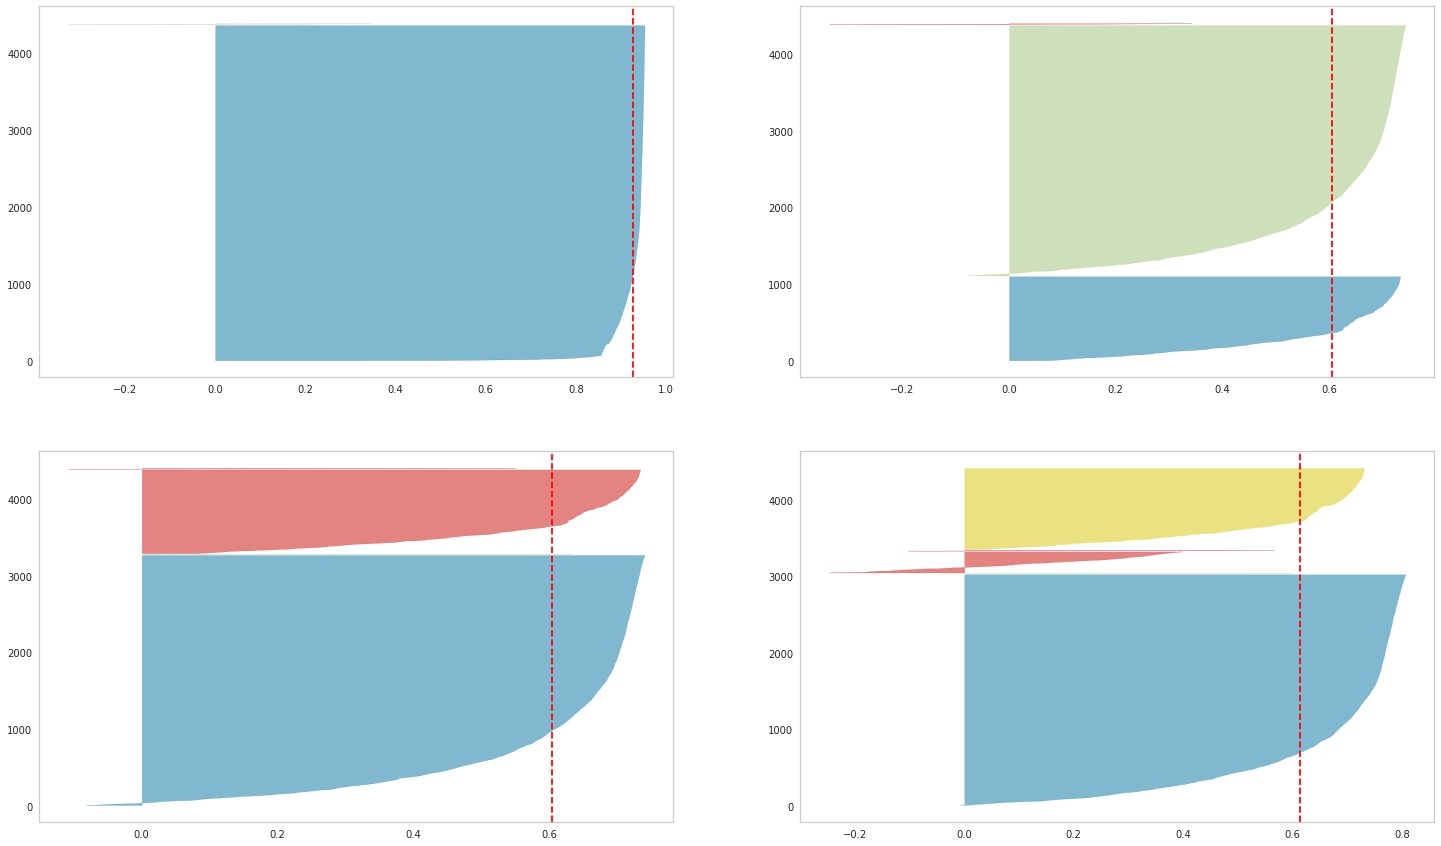

In [ ]:
# Plotando as análises de silhueta para K = 2, 3, 4, 5
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25,15))

# Definindo um loop para gerar os gráficos para cada K
for i in [2,3,4,5]:

  # Instanciando o KMeans para cada K
  km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100)
  q, mod = divmod(i, 2)

  # Plotando as Análises de Silhuetas
  visualizador = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
  visualizador.fit(df_rfm_normalizada)

De acordo com a Análise de Silhueta, valores próximos a 1 no eixo X, significa que os agrupamentos estão bastante densos e bem separados, enquanto que valores próximos de 0 significa que os agrupamentos estão se sobrepondo, e valores abaixo de 0 significa que os dados pertencentes ao agrupamento podem estar incorretos.

* O primeiro gráfico (superior esquerdo) com 2 agrupamentos obteve uma pontuação de quase 1, porém um agrupamento está com a pontuação negativa, o que inviabiliza a escolha desse agrupamento;

* O segundo gráfico (superior direito) com 3 agrupamentos possui um grupo que não atingiu a pontuação média, que é o grupo que possui pontuação negativa;

* O terceiro gráfico (inferior esquerdo) com 4 agrupamentos, possui 3 agrupamentos acima da pontuação média e o que está abaixo, está por pouco;

* O quarto gráfico (inferior direito) com 5 agrupamentos, possui 3 agrupamentos abaixo da pontuação média, o que inviabiliza essa quantidade de grupos.

Com a Análise de Silhueta, a melhor escolha para a quantidade de agrupamentos é de 4 grupos.

Pela Análise de Silhueta ser mais detalhada e informativa, vamos optar pelo número ótimo de agrupamentos como sendo quatro.

In [ ]:
# Instanciando novamente o KMeans para 4 agrupamentos
kmeans = KMeans(n_clusters=4, max_iter=100)
y_kmeans = kmeans.fit_predict(df_rfm_normalizada)

Agora que temos os agrupamentos, podemos incluir novamente a coluna `CustomerID`:

In [ ]:
# Incluindo novamente a coluna CustomerID
df_rfm_normalizada.loc[:,'CustomerID'] = df_rfm['CustomerID']

# Visualizando o DataFrame
df_rfm_normalizada.head()

,Recencia,Frequencia,Monetizacao,CustomerID
0,2.322023,-0.391720,14.478609,12346.0
1,-0.893733,0.382657,0.202528,12347.0
2,-0.169196,-0.266959,-0.036530,12348.0
3,-0.725005,-0.086271,-0.040306,12349.0
4,2.163220,-0.327188,-0.175701,12350.0


Já que temos os agrupamentos definidos, também podemos incluir uma coluna no DataFrame com essa informação:

In [ ]:
# Incluindo os agrupamentos no DataFrame
df_rfm_normalizada['Agrupamento'] = y_kmeans
df_rfm_normalizada.head()

,Recencia,Frequencia,Monetizacao,CustomerID,Agrupamento
0,2.322023,-0.391720,14.478609,12346.0,2
1,-0.893733,0.382657,0.202528,12347.0,1
2,-0.169196,-0.266959,-0.036530,12348.0,1
3,-0.725005,-0.086271,-0.040306,12349.0,1
4,2.163220,-0.327188,-0.175701,12350.0,0


Agora que temos os agrupamentos, vamos analisar cada um deles em relação a nossas métricas RFM:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

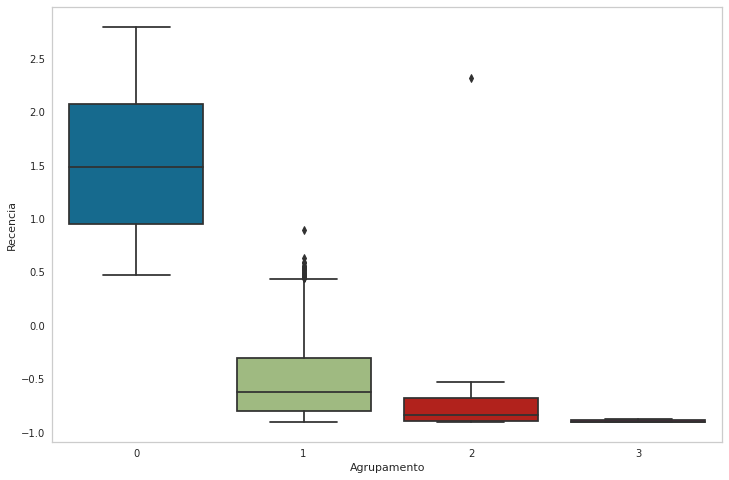

In [ ]:
# Plotando boxplots para o agrupamento em relação a métrica Recência
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Agrupamento', y='Recencia', data=df_rfm_normalizada, ax=ax);

Acima vemos que o grupo de clientes mais frequênte é o grupo 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

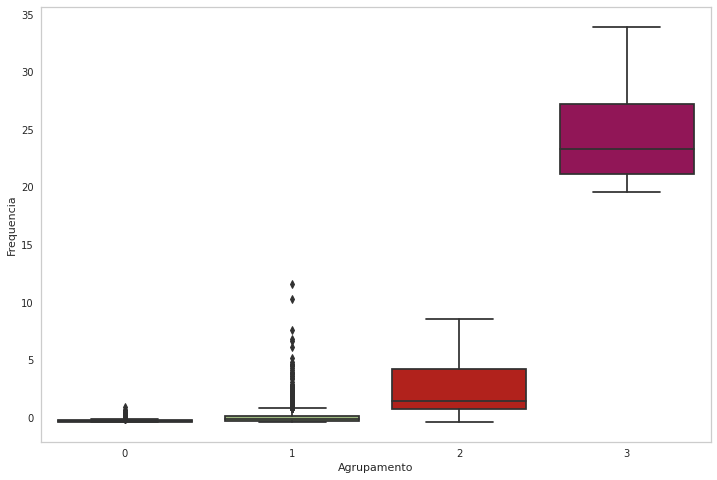

In [ ]:
# Plotando boxplots para o agrupamento em relação a métrica Frequência
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Agrupamento', y='Frequencia', data=df_rfm_normalizada, ax=ax);

O grupo mais frequênte é o 3.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

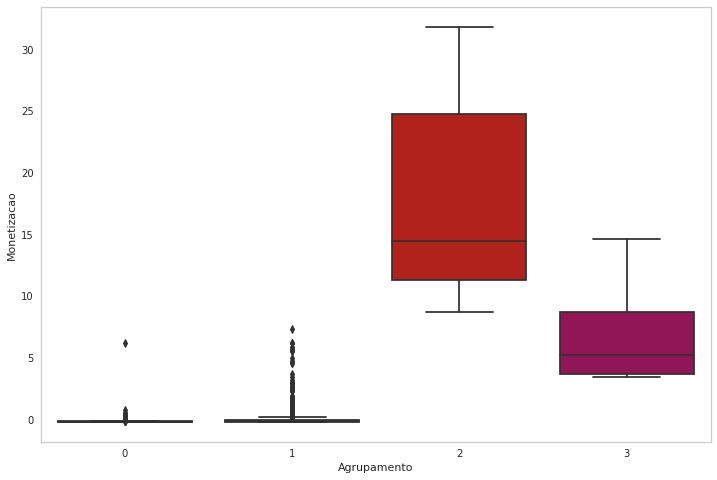

In [ ]:
# Plotando boxplots para o agrupamento em relação a métrica Monetização
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Agrupamento', y='Monetizacao', data=df_rfm_normalizada, ax=ax);

O grupo que mais possui valor monetário é o grupo 2.

Observando os boxplots de cada métrica RFM temos um grupo que se saiu melhor para cada métrica, então é interessante cruzarmos essas métricas para conseguir identificar qual o tipo do grupo.

Podemos separar os clientes em quatro categorias: 

* Melhores Consumidores: são frequentes, recentes e gastam bastante em seus pedidos;

* Novos Consumidores: são recentes, porém pouco frequentes e com gastos baixos em seus pedidos;

* Consumidores com risco de deixar o negócio (Churn): eram frequentes e gastavam muito em seus pedidos, porém já faz um tempo desde a sua última transação;

* Consumidores que já deixaram o negócio (Churned): possuem baixa frequência e pouco valor monetário, além de não possuírem transações recentes.

Vamos então identificar cada grupo:

* Grupo 0: são os menos recentes, menos frequentes e com o menor valor monetário, sendo assim podemos classificá-los como ***Consumidores que deixaram o negócio***;

* Grupo 1: não são recentes, pouco frequentes e com baixo valor monetário, ou seja, podemos classificá-los como ***Consumidores com risco de deixar o negócio***;

* Grupo 2: são recentes, relativamente frequentes e com alto valor monetário, sendo assim vamos classificá-los como ***Novos Consumidores***, mas como esse grupo possui um alto valor monetário, eles devem ser considerados também como ***Melhores Consumidores***;

* Grupo 3: são os mais recentes, os mais frequentes e com bom valor monetário, esse grupo deve ser considerado como ***Melhores Clientes***.

Agora que temos os grupos de clientes classificados, podemos definir algumas ações que o negócio poderia tomar para cada um deles.





In [ ]:
# Substituindo os valores numéricos pelos nomes dos Grupos
df_rfm_normalizada['Agrupamento'] = df_rfm_normalizada['Agrupamento'].replace([0,1,2,3],['Perdidos','Em Risco','Novos/Melhores','Melhores'])

# Checando se houve a alteração
df_rfm_normalizada

,Recencia,Frequencia,Monetizacao,CustomerID,Agrupamento
0,2.322023,-0.391720,14.478609,12346.0,Novos/Melhores
1,-0.893733,0.382657,0.202528,12347.0,Em Risco
2,-0.169196,-0.266959,-0.036530,12348.0,Em Risco
3,-0.725005,-0.086271,-0.040306,12349.0,Em Risco
4,2.163220,-0.327188,-0.175701,12350.0,Perdidos
...,...,...,...,...,...
4367,1.845615,-0.357303,-0.190334,18280.0,Perdidos
4368,0.882873,-0.370209,-0.199826,18281.0,Perdidos
4369,-0.834182,-0.344397,-0.190438,18282.0,Em Risco
4370,-0.873883,2.852058,-0.008214,18283.0,Em Risco


### Quais ações o negócio deveria tomar para cada grupo de clientes?

Agora que temos os grupos de clientes classificados, podemos dar algumas sugestões de como o negócio poderia lidar com eles:

* Grupo 0 - ***Consumidores que deixaram o negócio***: esses consumidores geralmente deixam de ser clientes do negócio, portanto realizar pesquisas para conhecer a razão por trás da perda do cliente e também melhorar a qualidade dos produtos e serviços podem ajudar e evitar perdas de mais clientes no futuro;

* Grupo 1 - ***Consumidores em Risco***: aproveitando a pesquisa sobre a saída dos clientes do negócio, pode-se direcionar campanhas de marketing que possam encorajar esse cliente de risco a realizar compras no negócio novamente;

* Grupo 2 - ***Melhores/Novos Consumidores***: necessitam de um melhor atendimento ao cliente e melhor experiência de compras no negócio para aumentar ainda mais o engajamento desses clientes, além disso também fazem parte dos melhores clientes para serem alvos de novos produtos ou serviços do negócio;

* Grupo 3 - ***Melhores Clientes***: estes são os clientes com grande potencial para serem alvos de novos produtos ou serviços do negócio.

Além do agrupamento realizado com o KMeans, podemos apreveitar as métricas RFM para criar um sistema de pontuação do cliente em relação à elas, onde cada cliente terá um valor entre 1 e 5 para cada uma delas.


## Calculando uma pontuação para cada cliente - RFM Score

Para segmentarmos nossas métricas dentro de um intervalo de 1 a 5, vamos checar os percentis de cada uma delas para 20%, 40%, 60% e 80%:

In [ ]:
# Copiando o DataFrame original para essa etapa
df_rfm_score = df_rfm.copy()

## Obtendo os dados estatísticos de cada métrica RFM

# Obtendo os valores que estão na métrica Recencia
r_percentis_20 = df_rfm['Recencia'].quantile(0.20)
r_percentis_40 = df_rfm['Recencia'].quantile(0.40)
r_percentis_60 = df_rfm['Recencia'].quantile(0.60)
r_percentis_80 = df_rfm['Recencia'].quantile(0.80)

# Obtendo os valores que estão na métrica Frequencia
f_percentis_20 = df_rfm['Frequencia'].quantile(0.20)
f_percentis_40 = df_rfm['Frequencia'].quantile(0.40)
f_percentis_60 = df_rfm['Frequencia'].quantile(0.60)
f_percentis_80 = df_rfm['Frequencia'].quantile(0.80)

# Obtendo os valores que estão na métrica Monetizacao
m_percentis_20 = df_rfm['Monetizacao'].quantile(0.20)
m_percentis_40 = df_rfm['Monetizacao'].quantile(0.40)
m_percentis_60 = df_rfm['Monetizacao'].quantile(0.60)
m_percentis_80 = df_rfm['Monetizacao'].quantile(0.80)

Agora que sabemos o valor de cada métrica RFM para os percentis, podemos definir uma função com os critérios e adicionar uma nova coluna no nosso DataFrame para cada pontuação.

Função para `Recencia`: vale lembrar que quanto menor for o valor nessa coluna, mais recente é o cliente, portanto um cliente com o menor valor em Recência deverá receber pontuação 5, enquanto aqueles que possuem altos valores devem receber uma pontuação 1.

In [ ]:
# Criando uma função para gerar uma nova coluna atribuindo os valores entre 1 a 5 para a Recência
def definindo_scores_recencia(row):
  if row['Recencia'] <= r_percentis_20: # Score 1
    return 5

  if (row['Recencia'] > r_percentis_20) & (row['Recencia'] <= r_percentis_40): # Score 2
    return 4

  if (row['Recencia'] > r_percentis_40) & (row['Recencia'] <= r_percentis_60): # Score 3
    return 3

  if (row['Recencia'] > r_percentis_60) & (row['Recencia'] <= r_percentis_80): # Score 4
    return 2

  if row['Recencia'] > r_percentis_80: # Score 5
    return 1

Função para `Frequencia`: quanto maior o valor nesta coluna, mais frequente é o cliente, então neste caso devemos usar a ordem crescente.

In [ ]:
# Criando uma função para gerar uma nova coluna atribuindo os valores entre 1 a 5 para a Frequência
def definindo_scores_frequencia(row):
  if row['Frequencia'] <= f_percentis_20: # Score 1
    return 1

  if (row['Frequencia'] > f_percentis_20) & (row['Frequencia'] <= f_percentis_40): # Score 2
    return 2

  if (row['Frequencia'] > f_percentis_40) & (row['Frequencia'] <= f_percentis_60): # Score 3
    return 3

  if (row['Frequencia'] > f_percentis_60) & (row['Frequencia'] <= f_percentis_80): # Score 4
    return 4

  if row['Frequencia'] > f_percentis_80: # Score 5
    return 5

Funcção para `Monetizacao`: assim como no caso da frequência, quanto maior o valor nessa coluna, maior a pontuação do cliente.

In [ ]:
# Criando uma função para gerar uma nova coluna atribuindo os valores entre 1 a 5 para a Monetização
def definindo_scores_monetizacao(row): 
  if row['Monetizacao'] <= m_percentis_20: # Score 1
    return 1

  if (row['Monetizacao'] > m_percentis_20) & (row['Monetizacao'] <= m_percentis_40): # Score 2
    return 2

  if (row['Monetizacao'] > m_percentis_40) & (row['Monetizacao'] <= m_percentis_60): # Score 3
    return 3

  if (row['Monetizacao'] > m_percentis_60) & (row['Monetizacao'] <= m_percentis_80): # Score 4
    return 4

  if row['Monetizacao'] > m_percentis_80: # Score 5
    return 5

Agora vamos aplicar a função para criar novas colunas para o DataFrame:

In [ ]:
# Criando uma coluna para a pontuação de Recência
df_rfm_score['R_Score'] = df_rfm_score.apply(lambda row: definindo_scores_recencia(row), axis=1)

# Criando uma coluna para a pontuação de Frequência
df_rfm_score['F_Score'] = df_rfm_score.apply(lambda row: definindo_scores_frequencia(row), axis=1)

# Criando uma coluna para a pontuação de Monetização
df_rfm_score['M_Score'] = df_rfm_score.apply(lambda row: definindo_scores_monetizacao(row), axis=1)

In [ ]:
# Checando se as novas colunas foram geradas corretamente
df_rfm_score.head()

,CustomerID,Recencia,Frequencia,Monetizacao,R_Score,F_Score,M_Score
0,12346.0,325,2,154367.20,1,1,5
1,12347.0,1,182,4310.00,5,5,5
2,12348.0,74,31,1797.24,2,3,4
3,12349.0,18,73,1757.55,4,4,4
4,12350.0,309,17,334.40,1,2,2


Assim como temos segmentações para agrupamentos, para a pontuação RFM também temos, por exemplo, um cliente com pontuação 5 nas três métricas RFM é considerado como seu **Melhor Cliente**.

Cada combinação dos valores das métricas (145, 555, 111, etc...) deve ser pensada e nomeada de acordo com o negócio, por exemplo: no artigo [How to calculate the RFM score for each customer](https://www.omniconvert.com/blog/rfm-score/) publicado no blog OMNICONVERT, são definidos 11 segmentos para cada pontuação de cliente com base num negócio sobre Vida Amorosa.

Para facilitar na visualização da pontuação de cada cliente, vamos unir as pontuações em uma única coluna:

In [ ]:
# Criando uma função
def rfm_score(row):
  pontuacao_rfm = (row['R_Score']*100) + (row['F_Score']*10) + row['M_Score']
  return int(pontuacao_rfm)

In [ ]:
# Criando uma nova coluna no DataFrame com a pontuação
df_rfm_score['RFM_Score'] = df_rfm_score.apply(lambda row: rfm_score(row), axis=1)

# Visualizando a nova coluna no DataFrame
df_rfm_score.head()

,CustomerID,Recencia,Frequencia,Monetizacao,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,325,2,154367.20,1,1,5,115
1,12347.0,1,182,4310.00,5,5,5,555
2,12348.0,74,31,1797.24,2,3,4,234
3,12349.0,18,73,1757.55,4,4,4,444
4,12350.0,309,17,334.40,1,2,2,122


Agora temos uma coluna que substitui três métricas, onde tinhamos `R_Score` = 5, `F_Score` = 1 e `M_Score` = 5, e agora temos `RFM_Score` = 515.

Agora vamos finalizar a nossa Análise RFM para vermos como ficaria as informações resumidas:

In [ ]:
# Obtendo um DataFrame resumido
df_rfm_resumo = df_rfm_score[['CustomerID','RFM_Score']]

# Unindo com os agrupamentos obtidos
df_rfm_resumo = pd.merge(df_rfm_resumo, df_rfm_normalizada[['CustomerID','Agrupamento']], on='CustomerID', how='inner')

# Visualizando o DataFrame resumido
df_rfm_resumo.head()

<IPython.core.display.Javascript object>

,CustomerID,RFM_Score,Agrupamento
0,12346.0,115,Novos/Melhores
1,12347.0,555,Em Risco
2,12348.0,234,Em Risco
3,12349.0,444,Em Risco
4,12350.0,122,Perdidos


No DataFrame acima podemos perceber que alguns agrupamentos não condizem com a pontuação do cliente, por exemplo, temos um cliente com pontuação 555 (***Melhor Cliente***) atribuído ao grupo ***Em Risco***.

## Possível falha de agrupamento pelo KMeans detectada

Vamos observar mais de perto os dois agrupamentos que mencionamos acima:

In [ ]:
# Observando os clientes no grupo de Melhores Cliente
df_rfm_resumo.loc[df_rfm_resumo['Agrupamento'] == 'Melhores']

,CustomerID,RFM_Score,Agrupamento
330,12748.0,555,Melhores
1300,14096.0,555,Melhores
1895,14911.0,555,Melhores
4042,17841.0,555,Melhores


Ao menos o grupo ***Melhores*** possui apenas clientes com pontuações 555, o que podemos dizer que neste caso o agrupamento foi bem adaptado aos dados.

Agora é a vez de observarmos o agrupamento ***Em Risco***:

In [ ]:
# Observando os clientes no grupo Em Risco
df_rfm_resumo.loc[df_rfm_resumo['Agrupamento'] == 'Em Risco']

,CustomerID,RFM_Score,Agrupamento
1,12347.0,555,Em Risco
2,12348.0,234,Em Risco
3,12349.0,444,Em Risco
5,12352.0,345,Em Risco
9,12356.0,445,Em Risco
...,...,...,...
4365,18277.0,311,Em Risco
4366,18278.0,211,Em Risco
4369,18282.0,511,Em Risco
4370,18283.0,554,Em Risco


In [ ]:
# Observando os clientes no grupo Em Risco que tenham pontuação 555
df_rfm_resumo['Agrupamento'].loc[(df_rfm_resumo['Agrupamento'] == 'Em Risco') & (df_rfm_resumo['RFM_Score'] == 555)].count()

304

Temos 304 clientes com pontuações máximas (555) atribuídos ao grupo ***Em Risco*** de forma errada.

Como o KMeans que utilizamos para realizar os agrupamentos é um algoritmo não supervisionado que busca agrupar os dados de acordo com a variância, podemos levantar a hipótese de que: as outliers que anteriormente detectamos realmente atrapalharam na decisão do KMeans, já que háviamos pontuado que as outliers influenciam bastante em análises e decisões estatísticas.

Para confirmar essa hipótese iremos realizar o agrupamento mais uma vez, porém, agora, com as pontuações RFM dos clientes, que por seus valores estarem em um intervalo entre 1 e 5, iremos "eliminar" a influência das outliers uma vez que todos os valores acima do valor do percentil 80% receberá um valor fixo igual a 5.

In [ ]:
# Criando um DataFrame apenas com as pontuações RFM dos clientes
df_hipotese = df_rfm_score[['R_Score','F_Score','M_Score']]

Primeiro vamos utilizar a **Regra do Cotovelo** (**Elbow Rule**) para encontramos a primeira dica do número ótimo de agrupamentos:

In [ ]:
# Definindo um loop para testarmos de 1 a 10 agrupamentos
ks_hipotese = range(1,10)
inertias_hipotese = []

# Executando o loop de testes
for k in ks_hipotese:
  # Instanciando o modelo KMeans para o número de agrupamentos K especificado pelo loop de teste
  model_hipotese = KMeans(n_clusters= k)

  # Adaptando o modelo
  model_hipotese.fit(df_hipotese)

  # Adicionando o valor da inércia na lista
  inertias_hipotese.append(model_hipotese.inertia_)

Plotando o Gráfico da **Regra do Cotovelo**:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

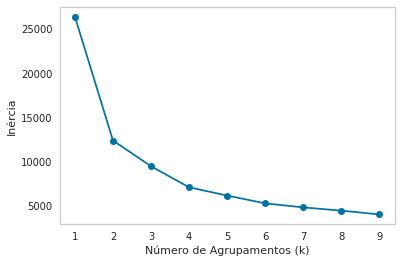

In [ ]:
# Plotando o gráfico da Regra do Cotovelo (Elbow Rule)
plt.plot(ks_hipotese, inertias_hipotese, '-o')
plt.xlabel('Número de Agrupamentos (k)')
plt.ylabel('Inércia')
plt.xticks(ks_hipotese)
plt.show()

Podemos ver no gráfico acima que a variância (inércia) passa a ser mais "uniforme" a partir de k=4, que seria nosso número ótimo.

Para termos mais confiabilidade nesse número, vamos também realizar a **Análise de Silhueta**:

<IPython.core.display.Javascript object>

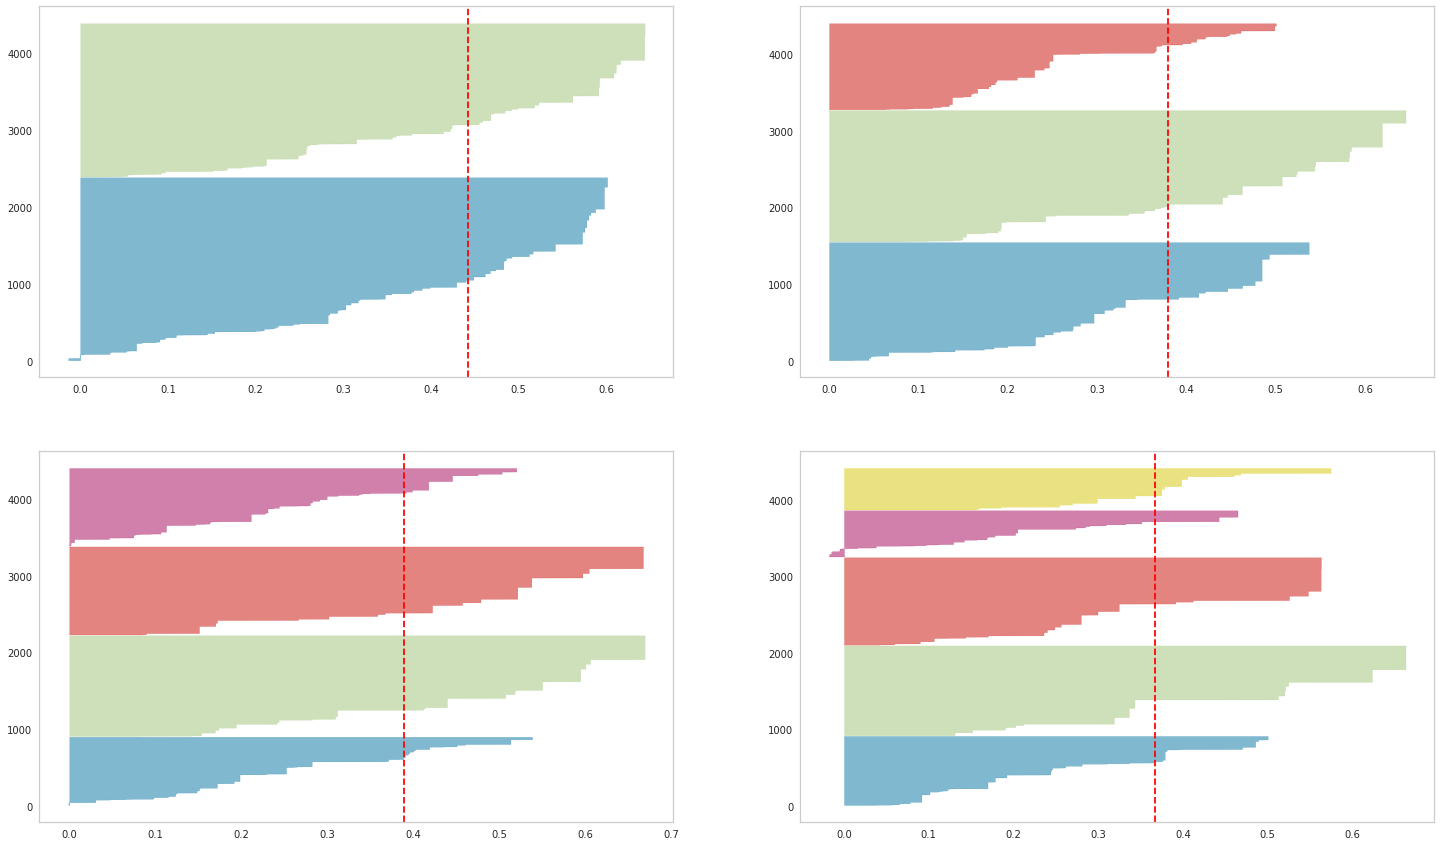

In [ ]:
# Plotando as análises de silhueta para K = 2, 3, 4, 5
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25,15))

# Definindo um loop para gerar os gráficos para cada K
for i in [2,3,4,5]:

  # Instanciando o KMeans para cada K
  km_hipotese = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100)
  q, mod = divmod(i, 2)

  # Plotando as Análises de Silhuetas
  visualizador_hipotese = SilhouetteVisualizer(km_hipotese, colors='yellowbrick', ax=ax[q-1][mod])
  visualizador_hipotese.fit(df_hipotese)

Aqui já é possível notar uma diferença em relação a análise feita com outliers presentes, temos agrupamentos bem separados e mais densos nas imagens, além de que em ambos os intervalos de K, os agrupamentos possuem pontuações acima da média.

Como temos os gráficos para K = 3 (superior direito) e K = 4 (inferior esquerdo) com pontuações próximas, vamos checar os valores de forma mais direta:

In [ ]:
# Instanciando e treianando o K-Means para obter a pontuação de K = 3 e K = 4
km_score_3 = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100) # K=3
km_score_4 = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100) # K=4

y_kmeans_3 = km_score_3.fit_predict(df_hipotese) # prevendo os agrupamentos para cada K
y_kmeans_4 = km_score_4.fit_predict(df_hipotese) 

# Obtendo a pontuação específica de K = 3 e K = 4
score_3 = silhouette_score(df_hipotese, y_kmeans_3, metric='euclidean')
score_4 = silhouette_score(df_hipotese, y_kmeans_4, metric='euclidean')

# Exibindo as pontuações
print('Pontuação da Análise de Silhueta para K = 3: {:.2f}'.format(score_3))
print('Pontuação da Análise de Silhueta para K = 4: {:.2f}'.format(score_4))

Pontuação da Análise de Silhueta para K = 3: 0.38
Pontuação da Análise de Silhueta para K = 4: 0.39


Vemos que a pontuação para K = 4 é superior, sendo assim, já que tanto a **Regra do Cotovelo** e a **Análise de Silhueta** recomendam o uso de quatro agrupamentos, vamos utilizar esse valor de K como nosso número ótimo.

Como já realizamos a previsão para obter as pontuações com a **Análise de Silhueta**, vamos apenas adicionar os IDs dos clientes no DataFrame da hipótese e depois os agrupamentos:

In [ ]:
# Incluindo a coluna CustomerID
df_hipotese.loc[:,'CustomerID'] = df_rfm_score['CustomerID']

# Incluindo os agrupamentos no DataFrame
df_hipotese['Agrupamento'] = y_kmeans_4

# Incluindo a coluna que une todas as métricas em uma
df_hipotese = pd.merge(df_hipotese, df_rfm_score[['CustomerID','RFM_Score']], on='CustomerID', how='inner')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pyforest/__init__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  install_extensions,


<IPython.core.display.Javascript object>

In [ ]:
# Visualizando o DataFrame da nossa hipótese
df_hipotese.head()

,R_Score,F_Score,M_Score,CustomerID,Agrupamento,RFM_Score
0,1,1,5,12346.0,3,115
1,5,5,5,12347.0,2,555
2,2,3,4,12348.0,3,234
3,4,4,4,12349.0,2,444
4,1,2,2,12350.0,0,122


Vamos checar os Boxplots para identificarmos os agrupamentos, começando com a pontuação de Recência:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

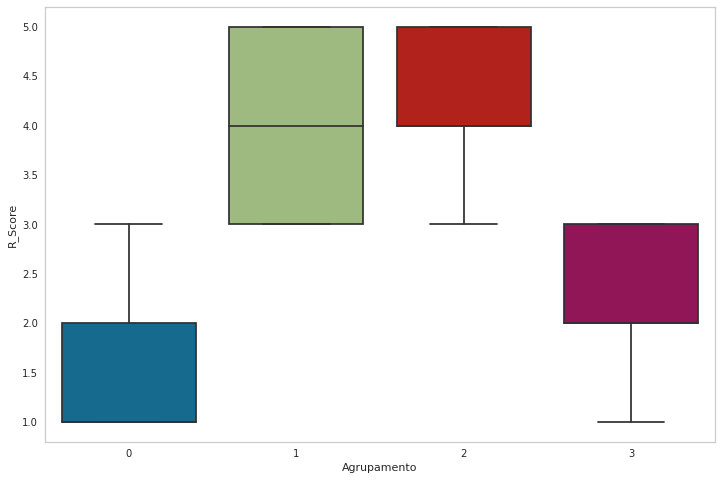

In [ ]:
# Plotando boxplots para o agrupamento em relação a pontuação de Recência
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Agrupamento', y='R_Score', data=df_hipotese, ax=ax);

Pontuação de Frequência:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

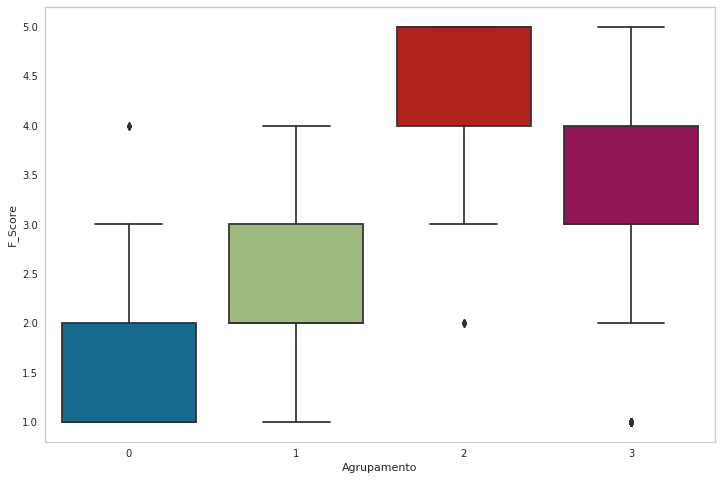

In [ ]:
# Plotando boxplots para o agrupamento em relação a pontuação de Frequência
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Agrupamento', y='F_Score', data=df_hipotese, ax=ax);

Pontuação do Valor Monetário:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

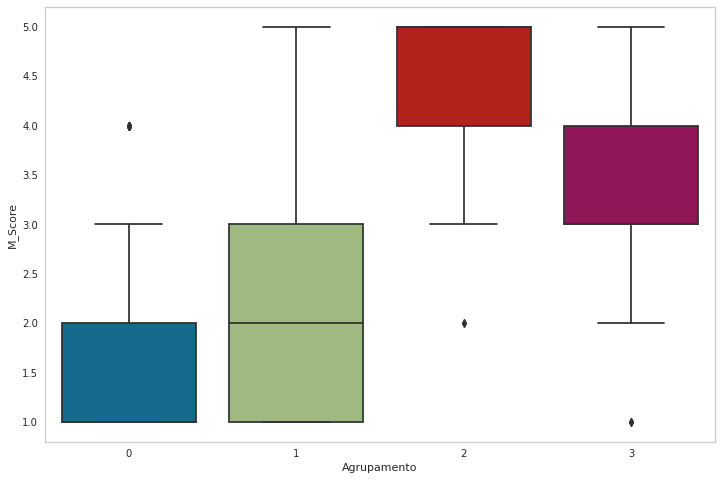

In [ ]:
# Plotando boxplots para o agrupamento em relação a pontuação do Valor Monetário
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='Agrupamento', y='M_Score', data=df_hipotese, ax=ax);

Utilizando as pontuações ao invés dos valores brutos que calculamos inicialmente, temos boxplots bem mais visíveis o que facilita na identificação dos grupos e também do que podemos encontrar dentro deles, por exemplo, no grupo 1 em relação à pontuação de Valor Monetário, podemos esperar ver clientes que possum tanto pontuações de 1 como também com pontuações de 5.

Vamos segmentar os grupos novamente:

* Grupo 0: são os menos recentes, menos frequentes e com menor valor monetário, podem ser **Perdidos**;

* Grupo 1: são recentes, relativamente frequentes e possuem todo o tipo de pontuação em valor monetário, esses podem ser nossos clientes **Novos**;

* Grupo 2: os mais recentes, frequentes e valorizados, ou seja, é o grupo dos **Melhores** clientes;

* Grupo 3: não são recentes, são frequentes e possuem um bom valor monetário, podendo ser então **Em Risco**.

In [ ]:
# Substituindo os valores numéricos pelos nomes dos Grupos
df_hipotese['Agrupamento'] = df_hipotese['Agrupamento'].replace([0,1,2,3],['Perdidos','Novos','Melhores','Em Risco'])

# Dropando as colunas R_Score, F_Score e M_Score já que agora temos a coluna RFM_Score
df_hipotese.drop(columns=['R_Score','F_Score','M_Score'], inplace=True)

# Checando se houve a alteração
df_hipotese

,CustomerID,Agrupamento,RFM_Score
0,12346.0,Em Risco,115
1,12347.0,Melhores,555
2,12348.0,Em Risco,234
3,12349.0,Melhores,444
4,12350.0,Perdidos,122
...,...,...,...
4367,18280.0,Perdidos,111
4368,18281.0,Perdidos,111
4369,18282.0,Novos,511
4370,18283.0,Melhores,554


Agora observando o DataFrame acima, parece que os agrupamentos estão de acordo com as pontuações individuais dos clientes.

Vamos olhar mais de perto o grupo **Melhores** e **Em Risco**:

In [ ]:
# Observando os clientes no grupo de Melhores Cliente
df_hipotese.loc[df_hipotese['Agrupamento'] == 'Melhores']

,CustomerID,Agrupamento,RFM_Score
1,12347.0,Melhores,555
3,12349.0,Melhores,444
5,12352.0,Melhores,345
9,12356.0,Melhores,445
10,12357.0,Melhores,355
...,...,...,...
4351,18257.0,Melhores,345
4352,18259.0,Melhores,435
4356,18263.0,Melhores,444
4361,18272.0,Melhores,555


In [ ]:
# Observando os clientes no grupo de Melhores Cliente
df_hipotese.loc[df_hipotese['Agrupamento'] == 'Em Risco']

,CustomerID,Agrupamento,RFM_Score
0,12346.0,Em Risco,115
2,12348.0,Em Risco,234
7,12354.0,Em Risco,134
16,12363.0,Em Risco,223
18,12365.0,Em Risco,124
...,...,...,...
4347,18251.0,Em Risco,225
4348,18252.0,Em Risco,343
4353,18260.0,Em Risco,255
4357,18265.0,Em Risco,233


In [ ]:
# Observando os clientes no grupo Em Risco que tenham pontuações 555
df_hipotese['Agrupamento'].loc[(df_hipotese['Agrupamento'] == 'Em Risco') & (df_hipotese['RFM_Score'] == 555)].count()

0

Observando os dois grupos e a quantidade de clientes com pontuações 555, podemos perceber que agora as pontuações individuais estão condizentes com os agrupamentos.

Isso conclui nosso teste de hipótese confirmando que as outliers influenciaram bastante na decisão do KMeans, além disso pudemos ver que utilizar dados dentro de um valor limite foi benéfico tanto na visualização gráfica quanto na qualidade dos agrupamentos formados pelo KMeans.

## Conclusão da Análise RFM

Neste projeto conseguimos criar novas features através dos dados originais que possibilitaram o processo de agrupamento feito pelo algoritmo não supervisionado KMeans, além disso conseguimos aproveitar as features criadas para desenvolver uma segunda parte da análise RFM, que é a pontuação RFM de cada cliente do negócio.

Conseguimos presenciar o impacto das outliers na formação de agrupamentos criados através do KMeans, onde conseguimos corrigir através de um teste de hipótese para comprovar que as causas eram as outliers.

Com esse teste de hipótese em que corrigimos a má formação dos grupos formados pelo KMeans, identificamos que apenas criar features de Recência, Frequência e Valor Monetário, não são suficientes para entregar resultados confiáveis para o negócio, sendo necessário criarmos uma pontuação individual para cada cliente e aí então realizar os agrupamentos. Além disso, a **Análise de Pontuações RFM** é bastante benéfica para o negócio, uma vez que essa pontuação individual pode ser utilizada para identificar os clientes que realmente valem o investimento do negócio.

É interessante lembrar que assim como definimos rótulos para cada agrupamento, também podemos definir para cada cliente através de sua pontuação RFM, assim podemos saber as características de cada um mesmo dentro de um determinado grupo.

Além da **Análise RFM** que realizamos, também podemos identificar anomalias nos dados, por exemplo, podemos checar se há sinais de fraudes ou manipulações de dados através da **Lei de Newcomb-Benford**.

# Análise de Anomalias com a Lei de Newcomb-Benford

Geralmente acreditamos que caso tivéssemos que escolher números aleatórios, a chance de escolhermos o número 1, por exemplo, é a mesma de escolhermos o número 9 ou 5. No entanto, uma lei descoberta em 1881 pelo astrônomo Simon Newcomb e posteriormente redescoberta pelo físico Frank Benford por volta de 1938, determina que, na verdade, as chances de escolhermos esses dígitos aleatórios não possuem a mesma probabilidade.

Essa lei assume que os primeiros dígitos de uma amostra de dados seguem uma distribuição logarítmica específica, onde o dígito "1" possui uma probabilidade de 30,1% de ser escolhido, e essa probabilidade vai diminuindo quanto maior for o dígito, por exemplo, o dígito "9" possui uma probabilidade de apenas 4,6%.

Abaixo podemos ver uma imagem da distribuição estatística dos primeiros dígitos entre 1 e 9:

<center><img alt='Benford Law'  src='https://www.monolitonimbus.com.br/wp-content/uploads/2017/11/lei_benford.png'></center>

Fonte: Monolitonimbus.

Através da aplicação dessa lei, é possível sinalizar se um conjunto de dados é suspeito de ter sido manipulado de forma rápida, além disso, essa lei vale para qualquer que seja a unidade utilizada (polegada, metro, ano-luz, etc.) e base numérica, o que torna difícil enganá-la.

De acordo com Bruno Mass, 2020, em seu artigo no blog iteris: [Lei de Benford como ferramenta para análise de dados](https://blog.iteris.com.br/lei-benford-aplicada-manipulacao-dados/), essa lei de Benford não é aplicável à todas as situações, sendo que o conjunto de dados precisa seguir algumas regras, que são descritas por ele como sendo:

* Domínio de dados: os números que compõem o conjunto de dados devem cobrir várias magnitudes de grandeza;

* Limites impostos (naturais ou não): os números não devem estar sujeitos a nenhum tipo de restrição prévia imposta pelo processo de escolha dos números;

* Aleatoriedade: os números do conjunto de dados não devem ser compostos por sequências ordenadas, por exemplo: números de notas fiscais;

* Quantidade de amostragem: devido à aleatoriedade, quanto menor a quantidade de observações do conjunto de dados, maior a probabilidade de distorção ou descolamento da curva de distribuição de Benford. Se tendermos a quantidade de observações ao infinito, a distorção tende a zero;

* Invariabilidade de escala: ao mudar a unidade de medida de um conjunto de números aderente à lei de Benford, é provável que o conjunto de dados permaneça aderente à lei.

Além dessas regras acima descritas pelo o autor do artigo, ele também oferece um ponto de vista estatístico para saber se o conjunto de dados é altamente aderente à aplicação da lei, que é quando:

* A média é maior que a mediana e a obliquidade (ou simetria) é positiva;

* Os números do conjunto de dados são formados pela combinação matemática de fatores (ex: quantidade x preço);

* Os números do conjunto de dados representam dados em níveis de transações individuais (faturas, despesas, etc.).

Agora que aprendemos um pouco sobre essa **Lei de Newcomb-Benford**, vamos conferir se o nosso conjunto de dados foi manipulado de alguma forma, que como temos dados que foram combinados matematicamente, estamos dentro de um dos pontos de vista descritos pelo autor do artigo mencionado acima, portanto podemos seguir com a aplicação da lei.



## Aplicando a Lei de Newcomb-Benford

Para aplicarmos a lei de Benford no nosso conjunto de dados, vamos utilizar duas bibliotecas Python desenvolvidas para essa lei, que são [Benford_py](https://github.com/milcent/benford_py) e [Benfordslaw](https://pypi.org/project/benfordslaw/#:~:text=benfordslaw%20is%20Python%20package%20to,is%20likely%20to%20be%20small.).

Vamos conferir se temos anomalias nas colunas `Recencia`, `Frequencia` e `Monetizacao`.

### Biblioteca Benford_py

In [ ]:
# Copiando o DataFrame com as metricas calculadas
df_benford = df_rfm.copy()

# Checando o DataFrame que iremos analisar
df_benford.head()

,CustomerID,Recencia,Frequencia,Monetizacao
0,12346.0,325,2,154367.20
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


Aplicando a lei de Benford na coluna de Recência:


Initialized sequence with 4267 registries.

Test performed on 4267 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_1_Dig                              
2            0.176091  0.232716  9.690829
3            0.124939  0.166159  8.120202


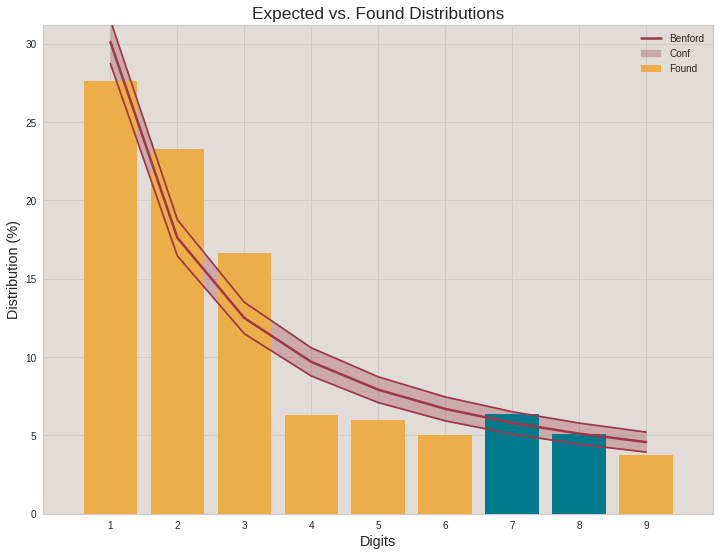

In [ ]:
# Obtendo a distribuição do primeiro dígito para a coluna Recencia
benford_recencia = bf.first_digits(df_benford['Recencia'], digs=1, confidence=95)

O gráfico acima demonstra que temos anomalias (colunas indicadas nas cores amarelas), em que as entradas com desvios positivos mais relevantes são os dígitos d = 2 e d = 3.

Aplicando a Lei de Benford na coluna de Frequência:


Initialized sequence with 4372 registries.

Test performed on 4372 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

Empty DataFrame
Columns: [Expected, Found, Z_score]
Index: []


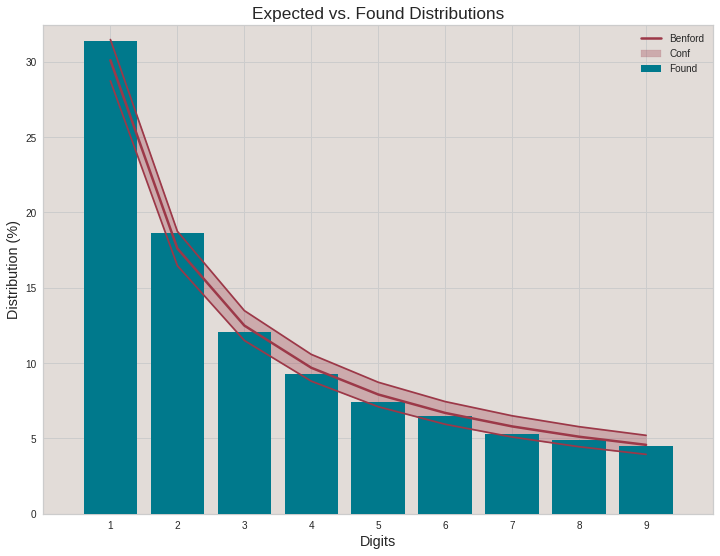

In [ ]:
# Obtendo a distribuição do primeiro dígito para a coluna Frequencia
benford_frequencia = bf.first_digits(df_benford['Frequencia'], digs=1, confidence=95)

No gráfico acima não temos nenhuma anomalia, os dados estão distribuídos de acordo com a lei de Benford.

Aplicando a Lei de Benford na coluna de  Monetização:


Initialized sequence with 4372 registries.

Test performed on 4372 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_1_Dig                              
3            0.124939  0.150961  5.180823


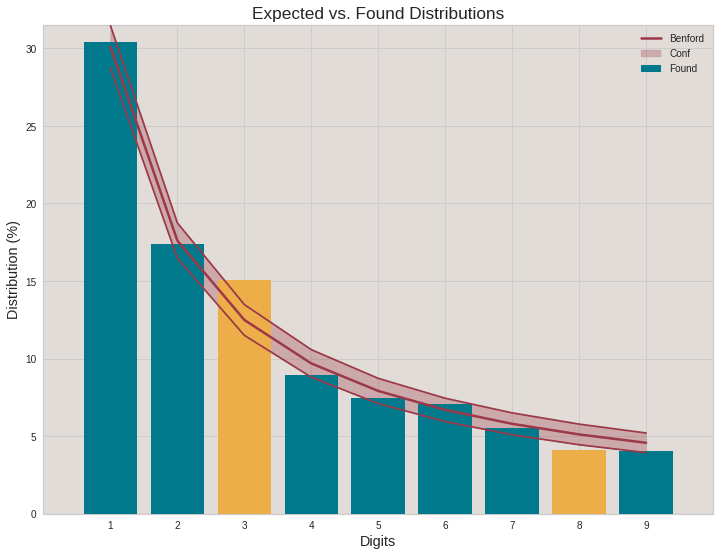

In [ ]:
# Obtendo a distribuição do primeiro dígito para a coluna Monetizacao
benford_monetizacao = bf.first_digits(df_benford['Monetizacao'], digs=1, confidence=95)

Já no gráfico acima também temos anomalias detectadas (colunas nas cores amarelas), onde o dígito com desvio positivo mais relevantes é d = 3.

Antes de falarmos sobre as anomalias detectadas, vamos fazer outra análise para a coluna `Frequencia` já que não detectamos anomalias, na qual iremos observar a distribuição com o segundo dígito numérico.


#### Testando a biblioteca Benford_py além do primeiro dígito numérico


Initialized sequence with 4372 registries.

Test performed on 3781 registries.
Discarded 591 records < 10 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_2_Dig                              
29           0.014723  0.020894  3.082815
21           0.020203  0.026977  2.902556
10           0.041393  0.050251  2.693722
28           0.015240  0.020365  2.506041
16           0.026329  0.032796  2.432677
11           0.037789  0.044962  2.270455
31           0.013788  0.017985  2.143045


/usr/local/lib/python3.7/dist-packages/benford/benford.py:761: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int)


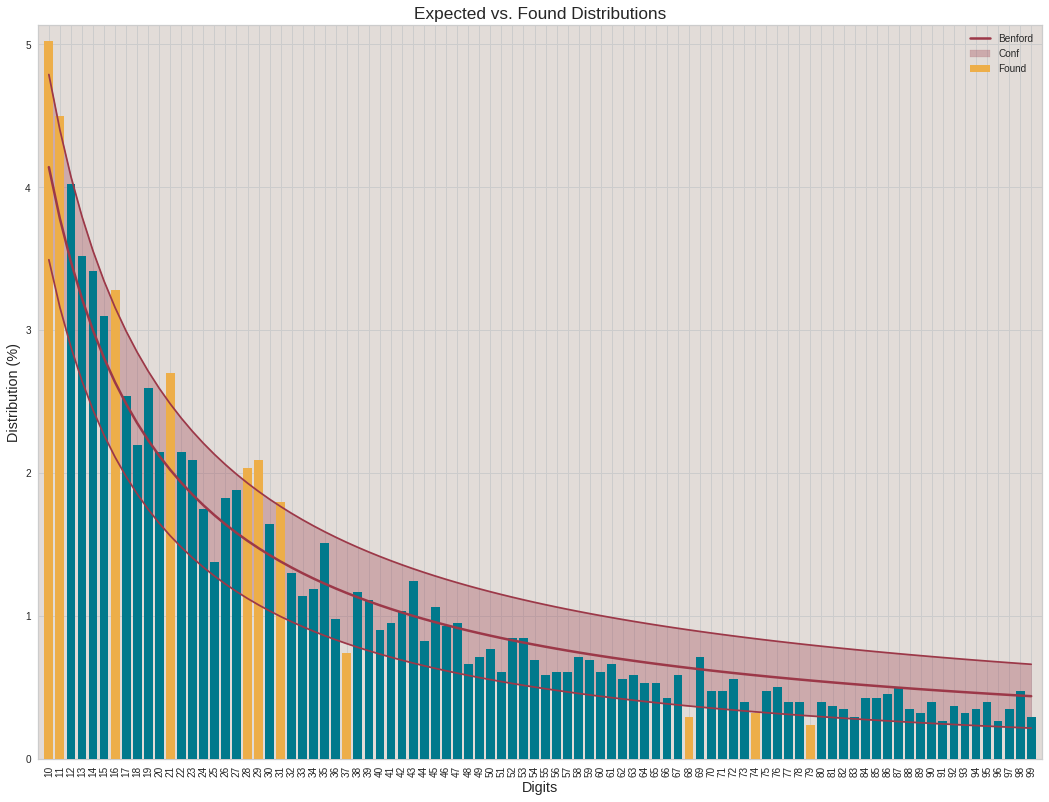

In [ ]:
# Obtendo a distribuição da coluna Frequencia com base no segundo dígito numérico
benford_frequencia_segundo = bf.first_digits(df_benford['Frequencia'], digs=2, confidence=95)

Através da Lei de Benford para o segundo dígito numérico já foi possível identificar anomalias, sendo elas mais significativas para d = 10, 11, 16, 21, 28, 29 e 31.

### Biblioteca Benfordslaw

In [ ]:
# Instanciando a biblioteca Benfordslaw
bl = benfordslaw(alpha=0.05)

Obtendo a distribuição para a coluna de Recência:

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=7.01242e-48, Tstat=242.404


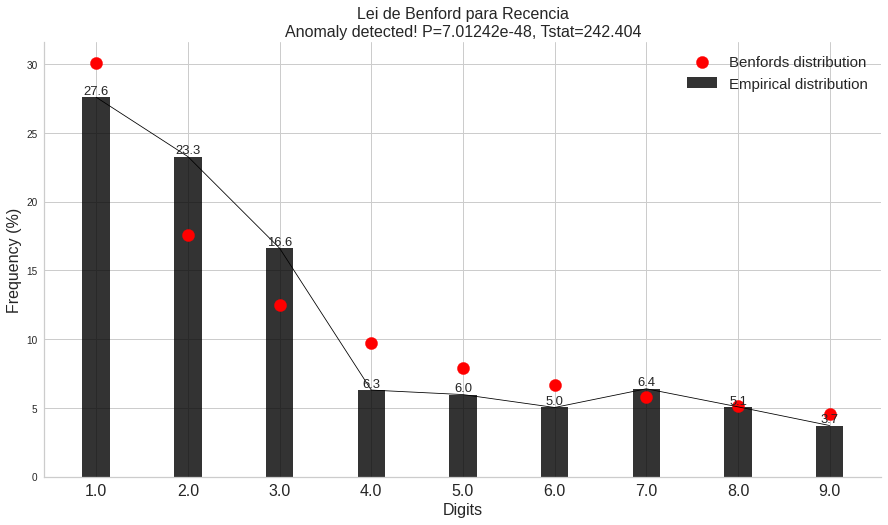

In [ ]:
# Extraindo as informações da coluna Recencia
info_recencia = df_benford['Recencia'].loc[df_benford['Recencia'] > 0].values

# Aplicando a lei de Benford
resultados_recencia = bl.fit(info_recencia)

# Plotando o gráfico com a distribuição e com o resultado
bl.plot(title='Lei de Benford para Recencia');

Podemos ver com o gráfico acima que foram detectadas anomalias.

Obtendo a distribuição para a coluna de Frequência:

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] No anomaly detected. P=0.233742, Tstat=10.4674


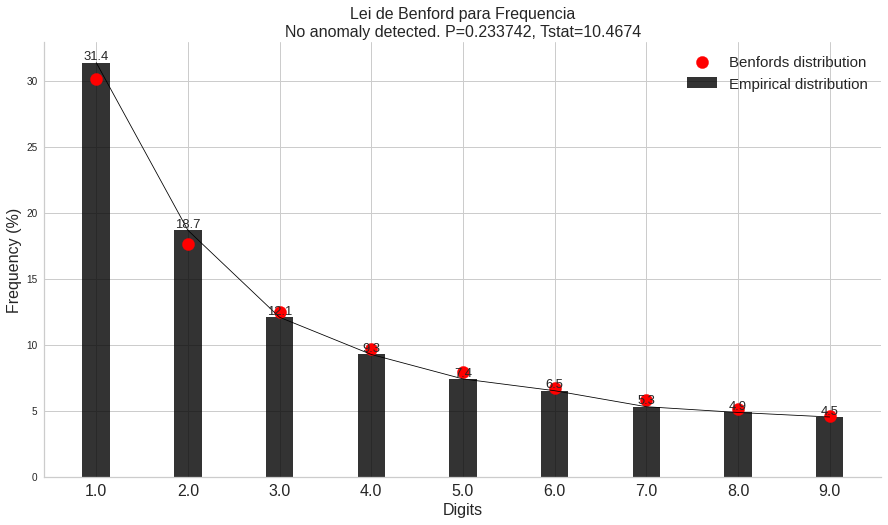

In [ ]:
# Extraindo as informações da coluna Frequencia
info_frequencia = df_benford['Frequencia'].loc[df_benford['Frequencia'] > 0].values

# Aplicando a lei de Benford
resultados_frequencia = bl.fit(info_frequencia)

# Plotando o gráfico com a distribuição e com o resultado
bl.plot(title='Lei de Benford para Frequencia');

Utilizando outra biblioteca também não detectamos anomalias na coluna `Frequencia` em relação ao primeiro dígito numérico.

Obtendo a distribuição para a coluna de Monetização:

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=2.28489e-06, Tstat=40.7868


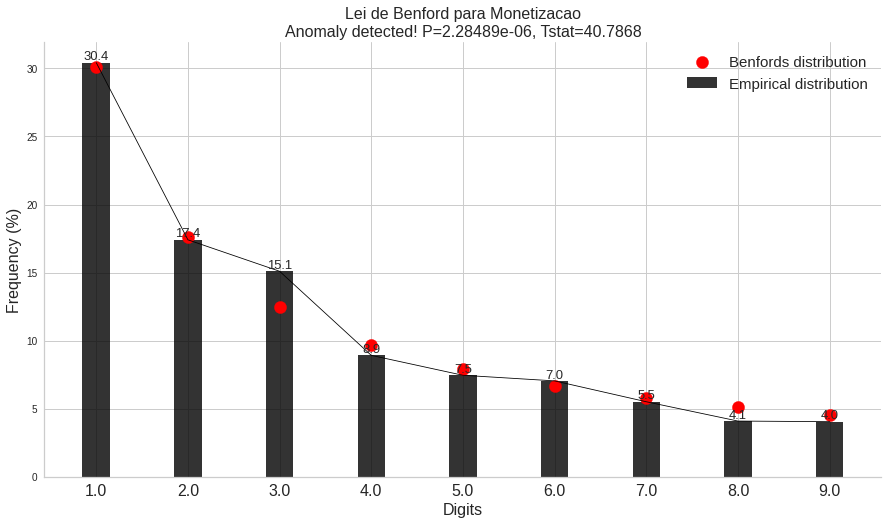

In [ ]:
# Extraindo as informações da coluna Monetizacao
info_monetizacao = df_benford['Monetizacao'].loc[df_benford['Monetizacao'] > 0].values

# Aplicando a lei de Benford
resultados_monetizacao = bl.fit(info_monetizacao)

# Plotando o gráfico com a distribuição e com o resultado
bl.plot(title='Lei de Benford para Monetizacao');

Também identificamos anomalias no gráfico acima.

Como realizamos um teste com o segundo dígito numérico para a coluna `Frequencia` que não possui anomalias vistas com o primeiro dígito, também vamos realizar a mesma análise para essa biblioteca.

#### Testando a biblioteca Benfordslaw além do primeiro dígito numérico

[benfordslaw] >Analyzing digit position: [2]
[benfordslaw] >[chi2] Anomaly detected! P=1.31565e-293, Tstat=1389.67


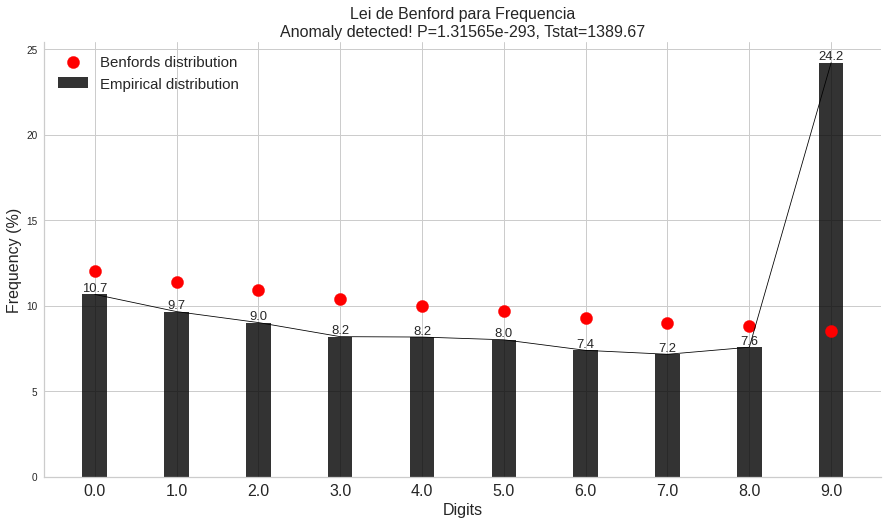

In [ ]:
# Instanciando novamente a biblioteca para o segundo dígito numérico
bl_segundo = benfordslaw(pos=2, alpha=0.05)

# Extraindo as informações da coluna Frequencia
info_frequencia_segundo = df_benford['Frequencia'].loc[df_benford['Frequencia'] > 0].values

# Aplicando a lei de Benford
resultados_frequencia_segundo = bl_segundo.fit(info_frequencia_segundo)

# Plotando o gráfico com a distribuição e com o resultado
bl_segundo.plot(title='Lei de Benford para Frequencia');

Também identificamos anomalias na coluna `Frequencia` através da aplicação da lei de Benford com o segundo dígito numérico.

## Conclusão da Análise com a Lei de Newcomb-Benford

Com a aplicação da Lei de Benford conseguimos detectar anomalias no nosso conjunto de dados, o que é um sinal de fraude ou manipulação de dados.

É importante ter em mente que a aplicação da Lei de Benford é utilizada para sinalizar possíveis fraudes e não confirmar que os dados estão fraudados, ou seja, se estivéssemos fazendo uma busca por fraudes ou possíveis manipulações da dados, usaríamos a Lei de Benford para levantar suspeitas e aí então fazer uma análise mais a fundo com outras técnicas para confirmá-las. Dessa forma, economizamos tempo e recursos para detectar as fraudes, já que não precisaríamos fazer uma análise complexa em todos os dados.

Quanto às anomalias encontradas no nosso conjunto de dados, podemos levantar duas hipóteses:

* Como são dados obtidos publicamente para fins educacionais, provavelmente os dados não são reais, o que causa as anomalias. Além do mais, essa hipótese acaba sendo reforçada pelo fato de não termos uma documentação ou descrição oficial sobre a base de dados.

* Nossos dados não possuem fraudes e nem dados manipulados, ocorreu apenas um acaso. Uma análise mais complexa seria necessária para confirmar essa hipótese em uma situação real com os dados do negócio.

# Referências

Análise RFM:

* https://medium.com/web-mining-is688-spring-2021/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-118f9ffcd9f0

* https://www.omniconvert.com/blog/rfm-score/

* https://medium.com/metis-eng/análise-rfm-um-pipeline-em-python-para-facilitar-a-vida-com-excel-1d468a833249

* https://vidadeproduto.com.br/analise-rfm/

Análise de Anomalias com a Lei de Newcomb-Benford:

* https://github.com/milcent/benford_py

* https://medium.com/thealexfreeman/benfords-law-9b93f21f4c40

* https://impa.br/noticias/marcelo-viana-na-folha-de-s-paulo-para-que-serve-a-lei-benford/

* https://blog.iteris.com.br/lei-benford-aplicada-manipulacao-dados/

* https://technoteinc.blogspot.com/2019/03/detectando-fraude-em-votos-com-lei-de.html

* https://www.linkedin.com/pulse/application-python-benfords-law-identification-fraud-le-acca/

* https://www.kaggle.com/code/maxreis/benford-s-law-applied-in-campeonato-paulista